# Mitigating Model Bias

In this notebook we explore how to mitigate model bias and achieve a fair machine learning model.  We will explore a post-processing step where we choose different thresholds for each group.


We will use the census adult income dataset from the UCI ML repository for our example.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('https://www.dropbox.com/s/j8scafz8tu8z8zc/census_adult_income.csv?dl=1')

In [3]:
df['gender'] = df['sex'].map({' Male':0,' Female':1})

In [4]:
df['target'] = df['income_bracket'].map({' <=50K':0,' >50K':1})

Now we choose the columns we want to use as predictor variables:
* Hours per week
* Gender
* Working class
* Marital status
* Occupation

In [5]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

ct = make_column_transformer(
    (StandardScaler(), ['hours_per_week']),
    (OneHotEncoder(), ["workclass", "marital_status", "education", "occupation"]),
    remainder="drop"
)

Now we split the data in to training and testing splits.

In [6]:
df_train=df.sample(frac=0.8,random_state=1234)
df_test=df.drop(df_train.index)

Let's train a logistic regression model on the data.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
pipeline = make_pipeline(ct,model)

pipeline.fit(df_train,df_train['target'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['hours_per_week']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['workclass',
                                                   'marital_status',
                                                   'education',
                                                   'occupation'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [8]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(df_test['target'],pipeline.predict(df_test))
print('precision:',precision[1])
print('recall:',recall[1])
print('fscore:',fscore[1])

precision: 0.7186147186147186
recall: 0.5164903546981954
fscore: 0.6010137581462709


Recall from before that this classifier does not satisfy the demographic parity fairness test, which requires that the positive prediction rate for the protected group be at least 80% of the rate for the other group.

In [9]:
df_test['pred'] = pipeline.predict(df_test)

In [10]:
pr_male = np.mean(df_test[df_test['gender']==0]['pred'])
pr_female = np.mean(df_test[df_test['gender']==1]['pred'])
pr_female/pr_male

0.23873117121316245

### Mitigating bias

Given a data point x, the classifier outputs its belief that the point should be classified as 1:

$$ Pr(y=1|x) $$.

By default, the classifier thresholds this value at 0.5 to separate the negative and positive classes.

The approach we explore here is to choose a custom threshold for each group in order to satisfy the fairness metrics above.

The function .predict_proba() returns the class probabilities from the model.  It actually returns two values: Pr(y=0|x) and Pr(y=1|x).

In [11]:
pipeline.predict_proba(df_test).shape

(6512, 2)

In [12]:
pipeline.predict_proba(df_test)

array([[0.73057708, 0.26942292],
       [0.90087794, 0.09912206],
       [0.98411339, 0.01588661],
       ...,
       [0.99002403, 0.00997597],
       [0.95284904, 0.04715096],
       [0.98289821, 0.01710179]])

In [13]:
df_test['pred_proba'] = pipeline.predict_proba(df_test)[:,1]

In [14]:
df_test['pred_proba']

3        0.269423
10       0.099122
15       0.015887
17       0.419649
20       0.212940
           ...   
32549    0.096139
32555    0.053018
32556    0.009976
32558    0.047151
32559    0.017102
Name: pred_proba, Length: 6512, dtype: float64

We can change the predictions of the classifier by changing the threshold.  If we lower the threshold, we will increase the positive prediction rate, and vice versa.

Test a few settings of the threshold for the protected group to see the effect on demographic parity.

In [15]:
df_test['pred'] = (pipeline.predict_proba(df_test)[:,1] >= 0.5) * 1
pos_rate_by_gender = df_test.groupby('gender')['pred'].mean()
pos_rate_by_gender[1]/pos_rate_by_gender[0]

0.23873117121316245

In [16]:
df_test['pred'] = (pipeline.predict_proba(df_test)[:,1] >= 0.3) * 1
pos_rate_by_gender = df_test.groupby('gender')['pred'].mean()
pos_rate_by_gender[1]/pos_rate_by_gender[0]

0.2895028179538592

In [17]:
df_test['pred'] = (pipeline.predict_proba(df_test)[:,1] >= 0.1) * 1
pos_rate_by_gender = df_test.groupby('gender')['pred'].mean()
pos_rate_by_gender[1]/pos_rate_by_gender[0]

0.4898775510749526

Make a line plot of how the demographic parity metric varies with the threshold for the protected group.  Is there any setting where the model achieves the 80% threshold?

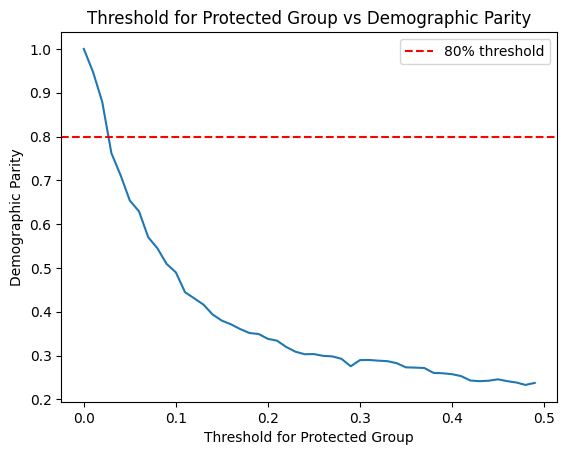

In [18]:
threshold = np.arange(0, 0.5, 0.01)
demo_par = []
for t in threshold:
  df_test['pred'] = (pipeline.predict_proba(df_test)[:,1] >= t) * 1
  pos_rate_by_gender = df_test.groupby('gender')['pred'].mean()
  demo_par.append(pos_rate_by_gender[1]/pos_rate_by_gender[0])
plt.plot(threshold, demo_par)
plt.axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
plt.xlabel('Threshold for Protected Group')
plt.ylabel('Demographic Parity')
plt.title('Threshold for Protected Group vs Demographic Parity')
plt.legend()
plt.show()

From this line plot, we see a decreasing trend in the demographic parity as the threshold for the protected group increases. Our model achieves the 80% demographic parity threshold when the threshold for the protected group is approximately less than 0.02.

Now make a 2D heatmap to show how the demographic parity metric varies with both the threshold for the protected group and the threshold for the other group.  

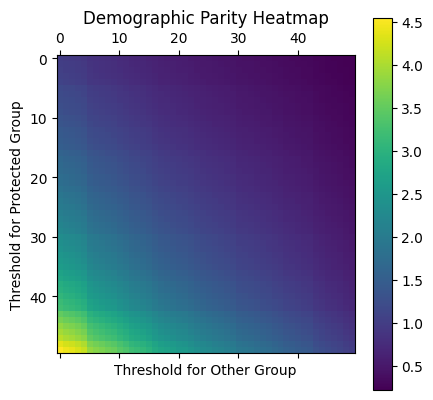

In [19]:
threshold = np.linspace(0.25, 0.75, 50)
demo_par = np.zeros((50, 50))
for i, t0 in enumerate(threshold): # male
  for j, t1 in enumerate(threshold): # female
    pr_male = np.mean(df_test[df_test['gender'] == 0]['pred_proba'] > t0)
    pr_female = np.mean(df_test[df_test['gender'] == 0]['pred_proba'] > t1)
    demo_par[i, j] = pr_female/pr_male
plt.matshow(demo_par)
plt.colorbar()
plt.xlabel('Threshold for Other Group')
plt.ylabel('Threshold for Protected Group')
plt.title('Demographic Parity Heatmap')
plt.show()

The heatmap seems to be darkest in the top right corner, and gets increasingly brighter as we move to the lower left corner. This means that a high threshold for the other group and low threshold for the protected group leads to the lowest demographic parity, whereas a high threshold for the protected group and low threshold for the other group leads to the highest demographic parity.

## Effect on recall

How does changing the threshold affect recall?  On top of your plot showing the effect of changing the protected group threshold, add a line showing the recall for each threshold setting.

Note that recall is simply the true positive rate for the entire test set.

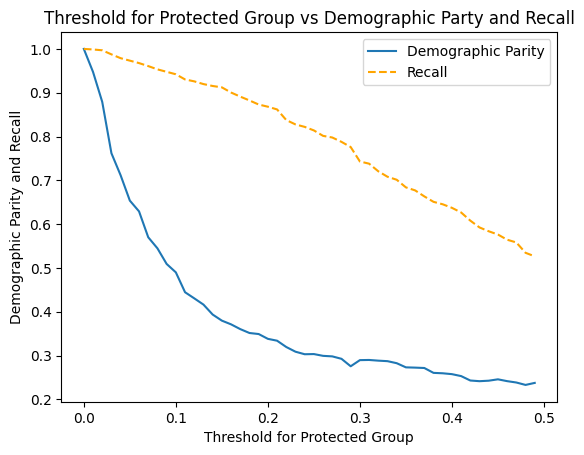

In [20]:
threshold = np.arange(0, 0.5, 0.01)
demo_par = []
recall = []
for t in threshold:
  df_test['pred'] = (pipeline.predict_proba(df_test)[:,1] >= t) * 1
  pos_rate_by_gender = df_test.groupby('gender')['pred'].mean()
  demo_par.append(pos_rate_by_gender[1]/pos_rate_by_gender[0])

  tp_female = len(df_test[(df_test['gender'] == 1) &
    (df_test['target'] == 1) &
    (df_test['pred'] == 1)])
  tp_male = len(df_test[(df_test['gender'] == 0) &
    (df_test['target'] == 1) &
    (df_test['pred'] == 1)])
  fn_female = len(df_test[(df_test['gender'] == 1) &
    (df_test['target'] == 1) &
    (df_test['pred'] == 0)])
  fn_male = len(df_test[(df_test['gender'] == 0) &
    (df_test['target'] == 1) &
    (df_test['pred'] == 0)])
  tp = tp_female + tp_male
  total = tp + fn_female + fn_male
  recall.append(tp/total)

plt.plot(threshold, demo_par, label='Demographic Parity')
plt.plot(threshold, recall, label='Recall', linestyle='--', color='orange')
plt.xlabel('Threshold for Protected Group')
plt.ylabel('Demographic Parity and Recall')
plt.title('Threshold for Protected Group vs Demographic Party and Recall')
plt.legend()
plt.show()

From this line plot, we see that increasing the threshold for the protected group decreases recall. Recall seems to decrease at a linear rate compared to demographic parity.

Design a metric that combines accuracy and fairness, and use grid search to find the threshold settings that produce the "best" model.

In [21]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [22]:
def acc_fair(y, y_pred, lambda_val):
  acc = accuracy_score(y, y_pred)
  precision, recall, fscore, support = precision_recall_fscore_support(y, y_pred, average='binary', zero_division=True)
  fairness = 1 - np.abs(precision - recall)

  acc_fair_score = acc - lambda_val * fairness
  return acc_fair_score

In [23]:
best_acc_fair_score = float('-inf')
best_threshold = 0
best_lambda = 0

threshold = np.arange(0, 0.5, 0.01)
lambda_val = np.arange(0, 11, 1)

for t in threshold:
  for l in lambda_val:
    df_test['pred_proba'] = pipeline.predict_proba(df_test)[:,1] >= t
    acc_fair_score = acc_fair(df_test['target'], df_test['pred_proba'], l)

    if acc_fair_score > best_acc_fair_score:
      best_acc_fair_score = acc_fair_score
      best_threshold = t
      best_lambda = l

print('Best Accuracy-Fairness Score:', best_acc_fair_score)
print('Best Threshold:', best_threshold)
print('Best Lambda Value:', best_lambda)

Best Accuracy-Fairness Score: 0.8343058968058968
Best Threshold: 0.42
Best Lambda Value: 0
